## Cross-Image Outlier Similarity

Notebook 1 found that 95% of images have position 193 as their outlier. Notebook 2 hinted that different image types activate different outlier positions.

**Question:** What do outliers encode? If they encode consistent meta-information, outlier embeddings should be similar across images.

In [2]:
from pathlib import Path

import duckdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

sns.set_theme(style="dark", font="JetBrains Mono")
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 14
PAD = 25

In [3]:
conn = duckdb.connect("open_images/open_images_embeddings.db")
IMAGES_DIR = Path("open_images/sample/images")

### Bucket Images by Outlier Position

In [4]:
def get_outlier_position(image_id: str, conn) -> int:
    """Find the most dissimilar token position for an image."""
    df = conn.sql(f"""
        SELECT token_position, embedding_vector 
        FROM image_token_embeddings 
        WHERE image_id = '{image_id}'
        ORDER BY token_position
    """).df()

    embeddings = np.stack(df["embedding_vector"].values)
    sim_matrix = cosine_similarity(embeddings, embeddings)
    mean_sim = sim_matrix.mean(axis=0)
    return int(np.argmin(mean_sim))

In [5]:
image_ids = (
    conn.sql("""
        SELECT DISTINCT image_id
        FROM image_token_embeddings
        ORDER BY image_id
    """)
    .df()
    .image_id.tolist()
)

outliers = {img_id: get_outlier_position(img_id, conn) for img_id in image_ids}

bucket_193 = [img_id for img_id, pos in outliers.items() if pos == 193]
bucket_48 = [img_id for img_id, pos in outliers.items() if pos == 48]

print(f"Bucket 193: {len(bucket_193)} images")
print(f"Bucket 48: {len(bucket_48)} images")

Bucket 193: 9530 images
Bucket 48: 105 images


### What Do These Buckets Look Like?

In [6]:
def show_bucket_samples(image_ids: list[str], title: str, n_samples: int = 8):
    """Display sample images from a bucket."""
    np.random.seed(42)
    samples = np.random.choice(
        image_ids, size=min(n_samples, len(image_ids)), replace=False
    )

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(title, fontsize=TITLE_FONTSIZE)

    for ax, img_id in zip(axes.flat, samples):
        img_path = IMAGES_DIR / f"{img_id}.jpg"
        if img_path.exists():
            ax.imshow(Image.open(img_path))
        ax.axis("off")

    plt.tight_layout()

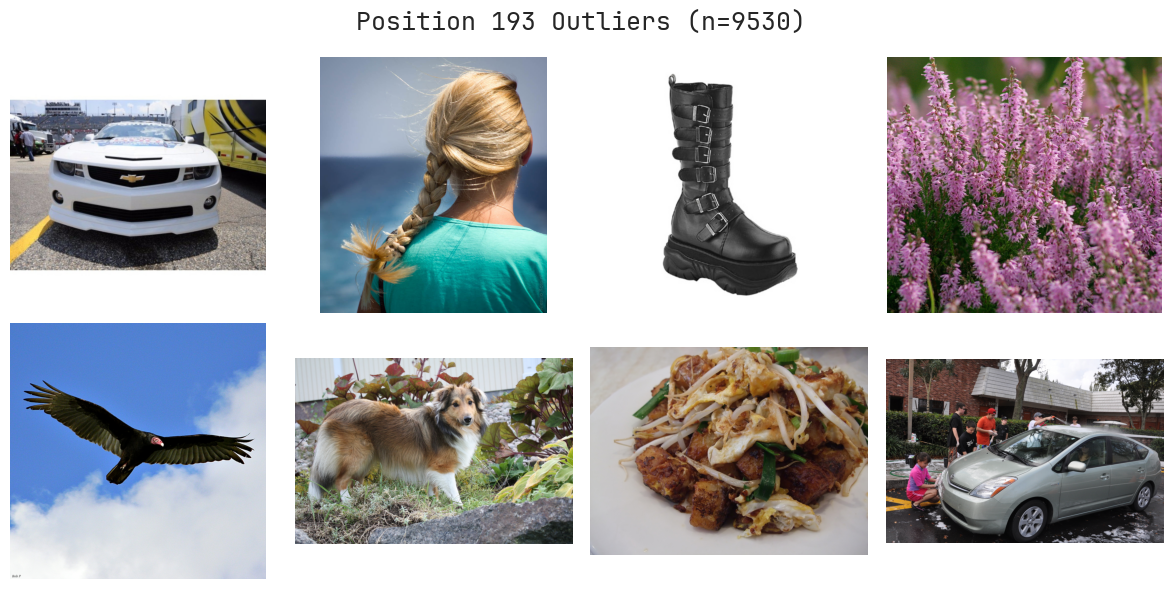

In [7]:
show_bucket_samples(bucket_193, f"Position 193 Outliers (n={len(bucket_193)})")

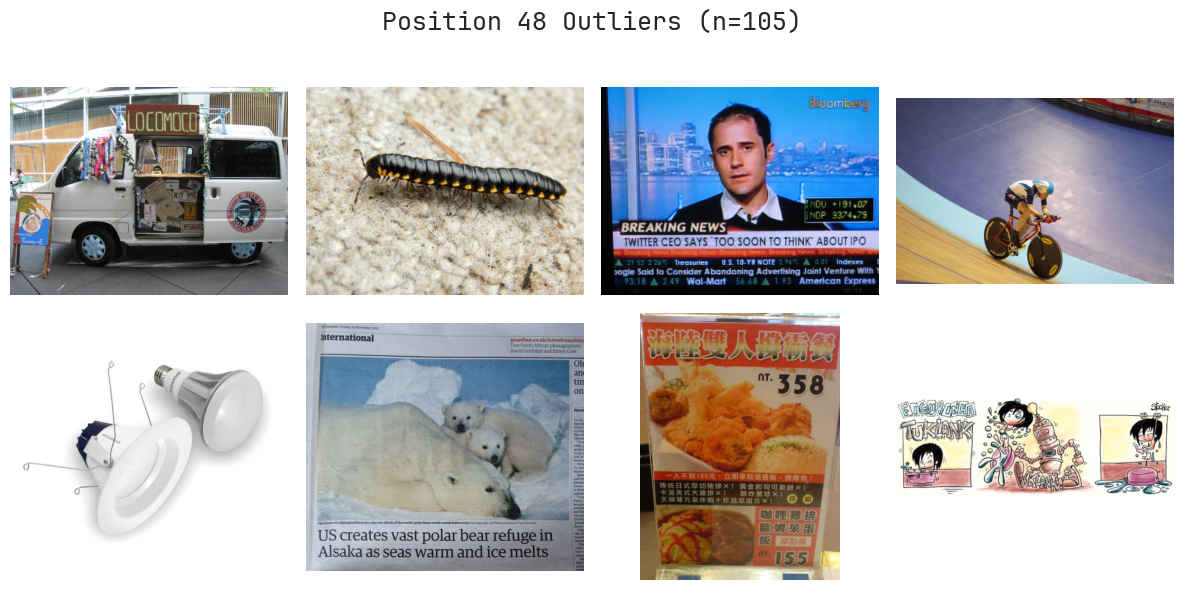

In [8]:
show_bucket_samples(bucket_48, f"Position 48 Outliers (n={len(bucket_48)})")

### Cross-Image Similarity

If position 193 encodes consistent meta-information, embeddings at position 193 should be similar across different images.

Compute cross-image similarity for all 256 positions.

In [9]:
def get_position_embeddings(image_ids: list[str], position: int, conn) -> np.ndarray:
    """Extract a specific position's embedding from multiple images."""
    id_list = ", ".join([f"'{img_id}'" for img_id in image_ids])

    df = conn.sql(f"""
        SELECT image_id, embedding_vector
        FROM image_token_embeddings
        WHERE image_id IN ({id_list})
        AND token_position = {position}
        ORDER BY image_id
    """).df()

    return np.stack(df["embedding_vector"].values)


def compute_cross_image_similarity(
    embeddings: np.ndarray, sample_size: int = 1000
) -> float:
    """Compute mean pairwise cosine similarity across images."""
    n = len(embeddings)

    if n > sample_size:
        idx = np.random.choice(n, sample_size, replace=False)
        embeddings = embeddings[idx]

    sim_matrix = cosine_similarity(embeddings, embeddings)
    upper_tri = np.triu_indices(len(embeddings), k=1)
    return sim_matrix[upper_tri].mean()

In [10]:
# Compute cross-image similarity for all 256 positions
cross_image_sim = []
for position in range(256):
    if position % 50 == 0:
        print(f"Processing position {position}...")
    embeddings = get_position_embeddings(bucket_193, position=position, conn=conn)
    sim = compute_cross_image_similarity(embeddings)
    cross_image_sim.append(sim)

cross_image_sim = np.array(cross_image_sim)

Processing position 0...
Processing position 50...
Processing position 100...
Processing position 150...
Processing position 200...
Processing position 250...


Position 193: 0.912
Mean (all positions): 0.507


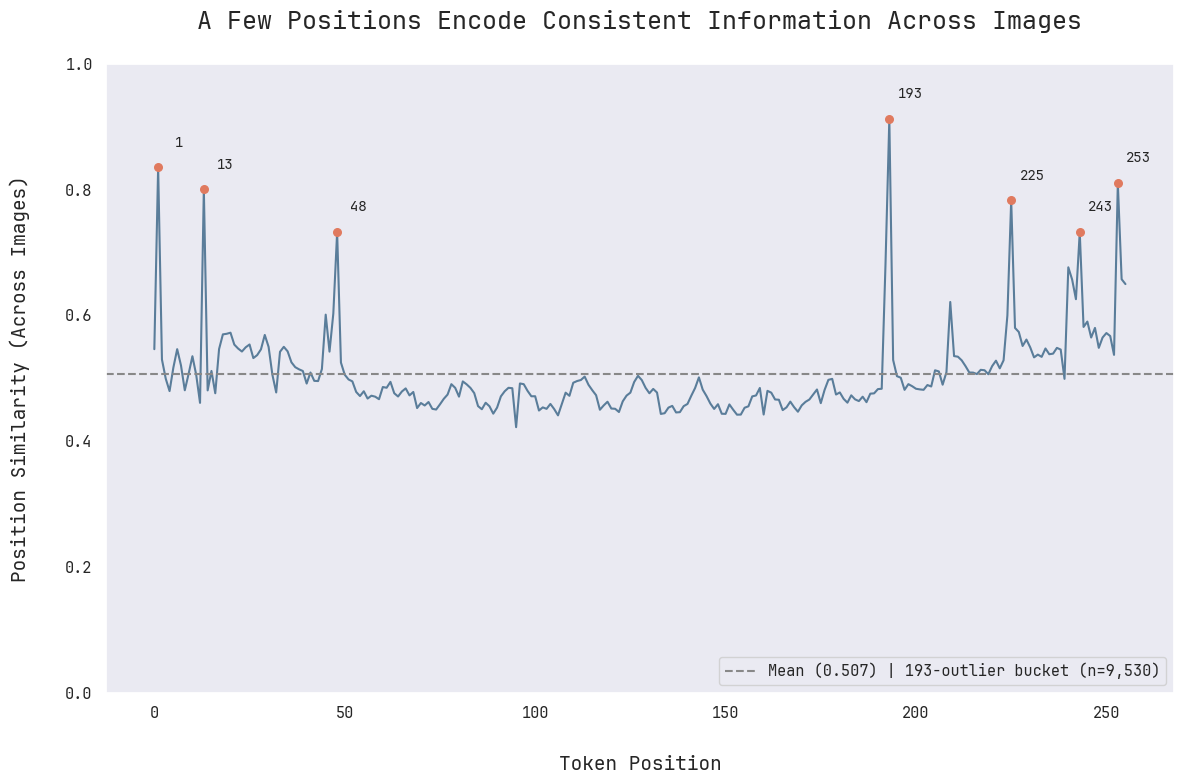

In [20]:
outlier_threshold = 0.7
outlier_positions = np.where(cross_image_sim > outlier_threshold)[0]

plt.figure(figsize=(12, 8))
plt.plot(cross_image_sim, color="#5a7d9a")
plt.scatter(
    outlier_positions,
    cross_image_sim[outlier_positions],
    color="#e07a5f",
    s=30,
    zorder=5,
)
for pos in outlier_positions:
    plt.annotate(
        str(pos),
        (pos, cross_image_sim[pos]),
        textcoords="offset points",
        xytext=(15, 15),
        ha="center",
        fontsize=10,
    )
plt.axhline(
    y=cross_image_sim.mean(),
    color="#888888",
    linestyle="--",
    label=f"Mean ({cross_image_sim.mean():.3f}) | 193-outlier bucket (n={len(bucket_193):,})",
)
plt.title(
    "A Few Positions Encode Consistent Information Across Images",
    fontsize=TITLE_FONTSIZE,
    pad=PAD,
)
plt.xlabel("Token Position", fontsize=LABEL_FONTSIZE, labelpad=PAD)
plt.ylabel("Position Similarity (Across Images)", fontsize=LABEL_FONTSIZE, labelpad=PAD)
plt.legend(loc="lower right")
plt.ylim(0, 1)
plt.tight_layout()

print(f"Position 193: {cross_image_sim[193]:.3f}")
print(f"Mean (all positions): {cross_image_sim.mean():.3f}")

### Interpretation

This plot mirrors Notebook 1, but inverted:

- **Notebook 1:** Position 193 has LOW within-image similarity (dissimilar to other positions)
- **Notebook 3:** Position 193 has HIGH cross-image similarity (consistent across images)

Whatever position 193 encodes, it's the same thing regardless of image content. This supports the hypothesis that outlier positions encode meta-information rather than image-specific content.